<a href="https://colab.research.google.com/github/sangho61/Personal-Projects/blob/master/Amazon_Movie_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8MB 10.9MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1618258 sha256=13992c71e97ac7a1bf5d8f0c83519c6927068726ac54e89b2a1b070bcd75f182
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Surprise library for collaborative filtering algorithm
from surprise import *
from surprise.model_selection import GridSearchCV
from surprise.accuracy import rmse, mae, fcp
from surprise.model_selection import cross_validate

# Others
import pickle
import json
from os import listdir


In [ ]:
import sklearn
print(sklearn.__version__)

0.22.2.post1


In [ ]:
# this project runs on Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#train_df = pd.read_json('reviews.training.json', lines=True)
#train_df.to_csv('reviews.train.csv')

In [ ]:
# load cleaned training data table
file_path = '/content/drive/MyDrive/Colab Notebooks/reviews_train_cleaned.csv'
train_df = pd.read_csv(file_path, names=["reviewerID", "asin", "overall"])

# Data Exploratory 

In [ ]:
print("Total ratings: %d" % (len(train_df)))

Total ratings: 1358026


In [ ]:
train_df.sample(n=100)

,reviewerID,asin,overall
803972,A2VURLCJKLJYC9,B00062IDEW,4
416737,A233A5MZSFQZ1Z,1558908358,5
1253293,A3LOQW7Z1CEWA6,B000AARKO4,3
399339,AY24PALJV97FG,B000VWYJ5Y,4
527287,A1WUMTJOASEL5F,B000P5FH2Q,4
...,...,...,...
802652,A1Q8WW227QVM4H,B004H83IKU,5
40121,ALIWLDJ50AHLB,B008WCP2GA,4
720064,A3A64289GZHBQD,0792107683,3
1085066,A1K3U413WXGDDL,B0060MYMPG,3


In [ ]:
train_df.describe()

,overall
count,1.358026e+06
mean,4.110995e+00
std,1.197396e+00
min,1.000000e+00
25%,4.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,5.000000e+00


In [ ]:
train_df['asin'].nunique()

50050

In [ ]:
train_df['reviewerID'].nunique()

123952

In [ ]:
train_df.dtypes

reviewerID    object
asin          object
overall        int64
dtype: object

In [ ]:
# check if there is any null values in train dataset
train_df.isnull().sum()

reviewerID    0
asin          0
overall       0
dtype: int64

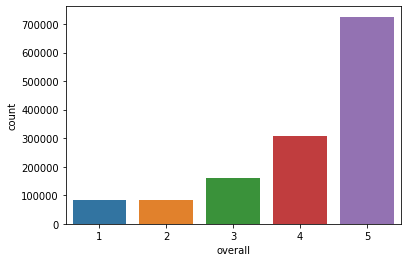

In [ ]:
# rating distributions
ax = sns.countplot(x="overall",data=train_df)

- Training dataset includes 1,358,026 ratings, and there are  50050 unique movies and 123952 unique users.
- Rating distribution shows users usually rated a movie 4 or 5 when they write a review.
- More than 75% of the rating data were 4 or 5 rates.

## Number of rated movies per user

In [ ]:
# number of rated movies per user distributions
# most of users rated one or two movies? might be skewed
ratings_per_user_count = pd.DataFrame(train_df.groupby('reviewerID')['overall'].mean())
ratings_per_user_count['ratings_per_user'] = pd.DataFrame(train_df.groupby('reviewerID')['overall'].count())
ratings_per_user_count.head()

,overall,ratings_per_user
reviewerID,,
A00295401U6S2UG3RAQSZ,4.00,5
A00348066Q1WEW5BMESN,5.00,5
A0040548BPHKXMHH3NTI,3.50,8
A00438023NNXSDBGXK56L,3.25,4
A0048168OBFNFN7WW8XC,5.00,7


In [ ]:
ratings_per_user_count.describe()

,overall,ratings_per_user
count,123952.000000,123952.000000
mean,4.202063,10.956064
std,0.729453,31.810722
min,1.000000,1.000000
25%,3.800000,4.000000
50%,4.333333,6.000000
75%,4.800000,9.000000
max,5.000000,1879.000000


In [ ]:
# 97 quantile to find the threhold for the outliers
ratings_per_user_count.quantile(.97)

overall              5.0
ratings_per_user    40.0
Name: 0.97, dtype: float64

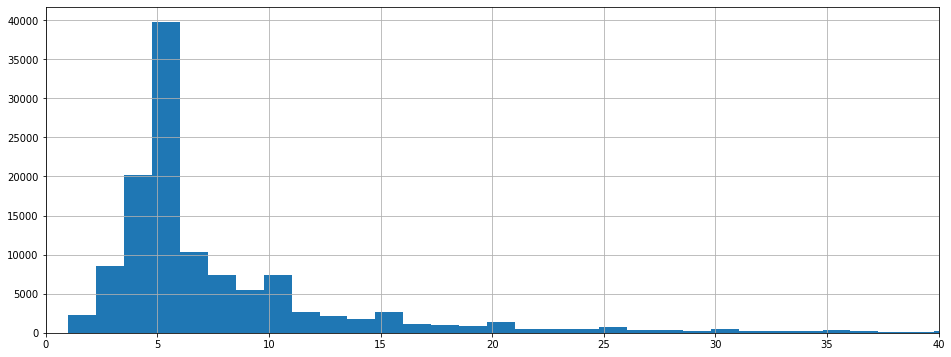

In [ ]:
# plot distribution over non outliers
plt.xlim(left=0, right = 40)
ratings_per_user_count['ratings_per_user'].hist(bins=1500, figsize=[16,6])

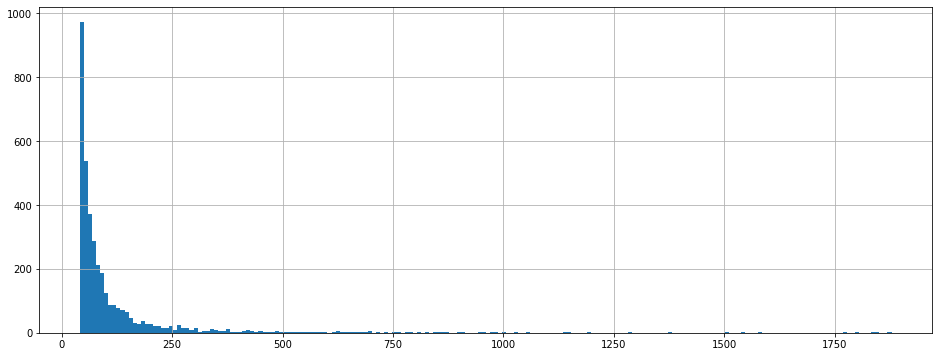

In [ ]:
# plot distribution over outliers 
ratings_per_user_count_outliers = ratings_per_user_count[ratings_per_user_count['ratings_per_user'] > 40]
ratings_per_user_count_outliers['ratings_per_user'].hist(bins=200, figsize=[16,6])

- Users in average rated 11 movies. Usually, users rated about 4~ 9 movies out of 50000 unique movies in the dataset. User who rated the most give ratings to 1879 movies.
- The above plot shows that the number of rated movies per user is right-skewed distribution. 97% of users gave ratings below 40 movies.
- Considering 50000 unique movies in the datset, this implies that they are a lot of missing data and a user-item matrix is very sparse.


## Number of ratings per movie

In [ ]:
# number of rated users per movie distributions
# popular movies will get lots of ratings? might be highly skewed
ratings_per_movie_count = pd.DataFrame(train_df.groupby('asin')['overall'].mean())
ratings_per_movie_count['ratings_per_movie'] = pd.DataFrame(train_df.groupby('asin')['overall'].count())
ratings_per_movie_count.head()

,overall,ratings_per_movie
asin,,
0005019281,4.512195,82
0005119367,4.767123,73
0307141985,5.000000,4
0307142469,4.741935,31
0307142477,2.600000,5


In [ ]:
ratings_per_movie_count.describe()

,overall,ratings_per_movie
count,50050.000000,50050.000000
mean,4.063479,27.133387
std,0.687280,58.769294
min,1.000000,1.000000
25%,3.700000,6.000000
50%,4.200000,10.000000
75%,4.577778,23.000000
max,5.000000,1785.000000


In [ ]:
ratings_per_movie_count.quantile(0.97)

overall                5.00
ratings_per_movie    151.53
Name: 0.97, dtype: float64

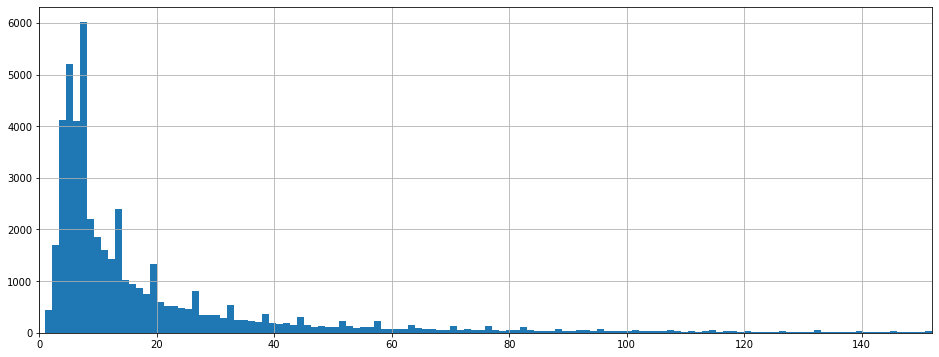

In [ ]:
# plot distribution over non-outliers
plt.xlim(left=0, right = 152)
ratings_per_movie_count['ratings_per_movie'].hist(bins=1500, figsize=[16,6])

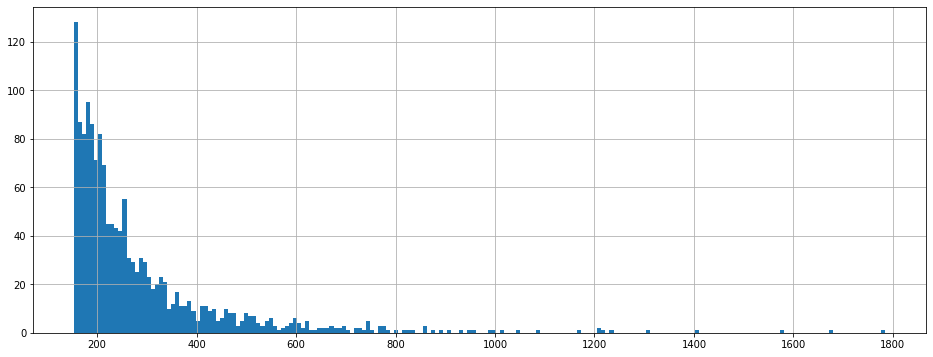

In [ ]:
# plot distribution over outliers 
ratings_per_movie_count_outliers = ratings_per_movie_count[ratings_per_movie_count['ratings_per_movie'] > 152]
ratings_per_movie_count_outliers['ratings_per_movie'].hist(bins=200, figsize=[16,6])

- Movie in average received 27 ratings. Most movies got ratings from 6 to 23. A movie which got most ratings received 1785 rates.
- Ratings per movie distribution is right-skewed as well. 97% of movies only got below 23 ratings. 
- This indicates that most of movies have missing ratings over users and  a user-item matrix would be a sparse matrix.


# Data Preprocessing

In [ ]:
# Preprocessing. We are using reviewer Id, Movie Id, and Rates
def read_reviews(path):
    try:
        df = pd.read_csv(path)
        df = df[['reviewerID', 'asin', 'overall']]
        return df
    except Exception as error:
        print("Cannot read file: "+repr(error))
    

In [ ]:
# prepare train dataset
#train_df = read_reviews('reviews.train.csv')
#train_df.to_csv('reviews_train_cleaned.csv', index=False, header=False)
#train_df.head()

In [ ]:
# load train dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/reviews_train_cleaned.csv'
reader = Reader(line_format='user item rating', sep=',')
train_data = Dataset.load_from_file(file_path, reader=reader)

In [ ]:
# load test dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/reviews.dev.csv'
dev_df = pd.read_csv(file_path)
reader = Reader(line_format='user item rating', sep=',')
devdataset_data = Dataset.load_from_df(pd.DataFrame.from_records(dev_df.values), reader=reader).build_full_trainset().build_testset()
#test_data = Dataset.load_from_file(file_path, reader=reader).build_full_trainset().build_testset()

In [ ]:
dev_df.head()

,reviewerID,asin,overall
0,A34DNO6UAH67Z0,B000CDSS22,5
1,A3APW42N5MRVWT,6305186774,2
2,A20D9VGCF3P13L,B004LWZW24,5
3,A82LIVYSX6WZ9,B00001U0DM,3
4,A3LRKDF5WU4ZDO,B00005JOZI,3


In [ ]:
# For Kaggle project submit
# prepare test dataset
# test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/reviews.test.unlabeled.csv')
# test_df['overall'] = None
# test_df.head()

,datapointID,reviewerID,asin,overall
0,85288b7fd23d48dcb4fd2c9b52a7fa3c,AT79BAVA063DG,B0009UVCQC,None
1,06f33eaec5bb4c20857cc1f9aee60fb4,A2DAHERP7HYJGO,B002ZG99TA,None
2,8f14a0d25996472d80a2e745b66f565a,A3NM0RAYSL6PA8,B0001NBNDY,None
3,50095c59950e444eb2b35afb00009f44,A2KODQS5LJGHF8,6304089767,None
4,abbbd3cd87d846b0a965ae7ce0ea1aaf,A2ULE2TYILL4BR,B000056MOF,None


# Baseline - Predict ratings from the movie's average rating


In [ ]:
# get mean overall from ratings per movie table
ratings_per_movie_count.head()

,overall,ratings_per_movie
asin,,
0005019281,4.512195,82
0005119367,4.767123,73
0307141985,5.000000,4
0307142469,4.741935,31
0307142477,2.600000,5


In [ ]:
# left join with ratings_per_movie_count table created in EDA
dev_baseline_df = dev_df.merge(ratings_per_movie_count, on='asin', how='left')
dev_baseline_df.head()

,reviewerID,asin,overall_x,overall_y,ratings_per_movie
0,A34DNO6UAH67Z0,B000CDSS22,5,4.652174,46.0
1,A3APW42N5MRVWT,6305186774,2,4.333333,6.0
2,A20D9VGCF3P13L,B004LWZW24,5,3.919149,235.0
3,A82LIVYSX6WZ9,B00001U0DM,3,2.444444,9.0
4,A3LRKDF5WU4ZDO,B00005JOZI,3,4.640000,200.0


In [ ]:
# compute RMSE
baseline_rmse = ((dev_baseline_df.overall_x - dev_baseline_df.overall_y) ** 2).mean() ** .5
print("Baseline RMSE : %f" % (baseline_rmse))

Baseline RMSE : 1.103958


In [ ]:
# find cases where predicted rating difference from the actual is greater than 1.5
baseline_df_error = dev_baseline_df[abs(dev_baseline_df['overall_x']-dev_baseline_df['overall_y']) > 1.5]
baseline_df_error.head()

,reviewerID,asin,overall_x,overall_y,ratings_per_movie
1,A3APW42N5MRVWT,6305186774,2,4.333333,6.0
4,A3LRKDF5WU4ZDO,B00005JOZI,3,4.640000,200.0
13,A2TAAFL2CH550H,6304431856,1,3.772727,22.0
37,A3I7OX03X6KDMN,B0006FFRB6,2,4.289474,38.0
38,A7FLQ9F7LEB8X,B00005JPS8,3,4.501597,626.0


In [ ]:
print("Total cases where predicted rating is off by more than 1.5 %d" %(baseline_df_error.shape[0]))

24781

# Base Functions for Models

In [ ]:
def grid_search_algo(data, algorithm, param_grid):
  """ Return grid serach results with best paramter info

  Performs GridSearchCV with 3 cross validation using RMSE measures
  """

  gs = GridSearchCV(algorithm, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
  gs.fit(data)

  # best RMSE score
  print(gs.best_score['rmse'])

  # combination of parameters that gave the best RMSE score
  print(gs.best_params['rmse'])

  return gs

# Model 1 - Memory Based Collaborative Filtering -  CoClustering

In [ ]:

param_grid = {
    'n_cltr_u' : [3, 6, 9, 12, 15],
    'n_cltr_i' : [3, 6, 9, 12, 15],
    'n_epochs': [40] }
#gs = grid_search_algo(train_data, CoClustering, param_grid)
print(gs.cv_results)

Best fit param: {'n_cltr_u': 3, 'n_cltr_i': 3, 'n_epochs': 40}

## Evaluate on the validation data

# Model 2 - Model Based Collaborative Filtering - SVD

In [1]:
def evaluate_algo(data, algorithm):
  """ Return rmse results for different n latent factors

  Evaluate algorithm with RMSE to find n_factors param
  """
  rmse_algorithm = []
  #  possible values of n_factors
  for k in range(1, 51, 5):
      algo = algorithm(n_factors = k)
      # 3 folds
      algo_perf = cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=True)
      rmse_algorithm.append(algo_perf['test_rmse'].mean())
  return rmse_algorithm

In [2]:
#print(evaluate_algo(train_data, SVD))

In [3]:
param_grid = {
    # utilize evaluate_algo to find possible values for n_factors param
    'n_factors': [10, 15, 20, 25, 30],
    'n_epochs': [40],
    'lr_all': [0.005, 0.01],
    'reg_all': [0.02, 0.1]}
#grid_search_algo(train_data, SVD, param_grid)

GridSearch with 3 folds shows that the best fit parameters for SVD is as below.

* {'n_factors': 10, 'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.1}

* RMSE on test folds : 1.015649335610912

## Evaluate on the validation data

In [4]:
#algo = gs.best_estimator['rmse']
algo = SVD(n_factors=10, n_epochs=40, lr_all=0.005, reg_all=0.1)
algo.fit(train_data.build_full_trainset())

NameError: ignored

In [ ]:
print("dev shape: %s" % (dev_df.shape,))
# evaluate on the validation data (Dev Data)
predictions = algo.test(devdataset_data)

# Then compute RMSE
svd_dev_rmse = rmse(predictions)

In [ ]:
dev_errors = []
for prediction in predictions:
  dev_errors.append(abs(prediction.r_ui - prediction.est))

In [ ]:
svd_dev_errors_df = pd.DataFrame({"diff" : dev_errors})
svd_dev_errors_df.head()

In [ ]:
#  distributions over error cases
svd_dev_errors_df['diff'].hist()

In [ ]:
baseline_df_error = svd_dev_errors_df[svd_dev_errors_df['diff'] > 1.5]
baseline_df_error.shape[0]

# Discussion and Results

- This project recommend movies to user by predicting ratings for a given user and movie set. A well known collaborative filetring algorithm which is SVD using SGD is used to predict missing ratings and results is compared to the baseline which is just average over all ratings for each movie.
- SVD Parameters: 10 factors and 3 cross validations
- About dataset
  - Train data size: 1,358,026, about 50000 unique movies, 123952 unique movies
  - Test data size 169,753

- Results
  - SVD RMSE: 1.000, Baseline RMSE: 1.104
  - SVD performed slightly better than the basleine. RMSE indicates that in average both models had about 1 rating off from the actual with having the scale from 1 to 5
- Error Analysis
  - Cases where the difference between actual and predicted values are greater than 1.5 -> SVD: 20567 cases baseline: 24781 cases


# Challenges and Future Works
- EDA shows that in most cases movies only get ratings from a few users. This aligns with the real world that users only see selected number of movies out of total movies. This can be problem in using SVD since a user-movie matrix is highly sparse and there would be many missing items to find latent factors. In a real case, it would make more sense to build a hybrid model which would use SVD on dense users and popular movies and predict ratings of unpopular movies based on their historical averages or their contents/meta information.
- It would be interesting to take account timestamp information in a model

# Kaggle submission Test data

In [ ]:
for i, row in test_df.iterrows():
    row['overall'] = round(algo.predict(row['reviewerID'], row['asin']).est)
test_df.head()
header = ['datapointID', 'overall']
test_df.to_csv('reviews.test.labeled_v3.csv', columns=header, index=False)

In [ ]:
dev_df = pd.read_csv('reviews.dev.csv')
preds = []
for i, row in dev_df.iterrows():
    preds.append(algo.predict(row['reviewerID'], row['asin']).est)

dev_df['preds'] = pd.Series(preds, index=dev_df.index)
dev_df.head()